# AlexNet classifier training

This notebook trains the AlexNet classifier defined in `alexnet_classifier.py` on the Airbus aircraft classification dataset so that we can export weights for later detector initialization.


In [1]:
from pathlib import Path
from typing import Dict
import random
import math
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import optuna

from alexnet_classifier import build_alexnet_classifier, IMAGENET_MEAN, IMAGENET_STD


In [2]:
# Reproducibility helpers
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

# Paths and hyperparameters
data_dir = Path("dataset/airbus-aircrafts-sample-dataset-classification")
sample_limit = 10000
train_ratio = 0.8
batch_size = 64
num_epochs = 20
learning_rate = 1e-4
weight_decay = 1e-4
# Using >0 workers inside notebooks on Windows can deadlock, so default to 0.
num_workers = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [3]:
if not data_dir.exists():
    raise FileNotFoundError(f"Dataset directory not found: {data_dir}")

base_dataset = datasets.ImageFolder(root=data_dir)
total_available = len(base_dataset.samples)
selected_count = min(sample_limit, total_available)
if selected_count < sample_limit:
    print(f"Requested {sample_limit} samples but only {total_available} are available. Using {selected_count} images.")
else:
    print(f"Using a random subset of {selected_count} samples for training and validation.")

shuffled_indices = list(range(total_available))
random.shuffle(shuffled_indices)
selected_indices = shuffled_indices[:selected_count]
selected_samples = [base_dataset.samples[idx] for idx in selected_indices]

train_count = int(train_ratio * selected_count)
val_count = selected_count - train_count
train_samples = selected_samples[:train_count]
val_samples = selected_samples[train_count:]
class_names = base_dataset.classes

print(f"Classes: {class_names}")
print(f"Train images: {train_count}, Validation images: {val_count}")

train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)


class AirbusClassificationDataset(Dataset):
    def __init__(self, samples, transform):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        with Image.open(image_path) as img:
            img = img.convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, label


train_dataset = AirbusClassificationDataset(train_samples, train_transform)
val_dataset = AirbusClassificationDataset(val_samples, val_transform)


Using a random subset of 10000 samples for training and validation.
Classes: ['aircraft', 'background']
Train images: 8000, Validation images: 2000


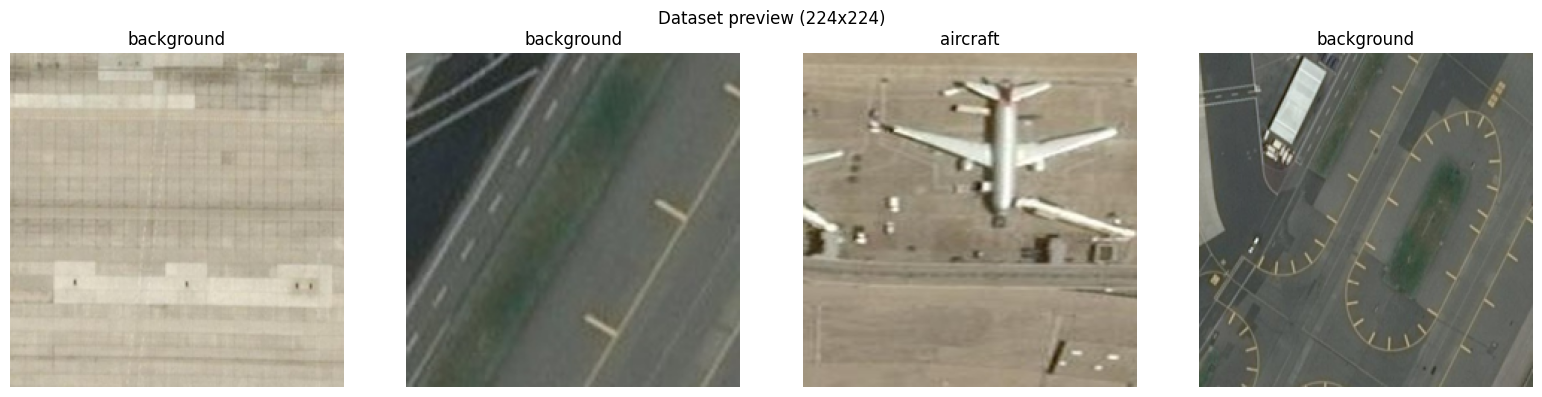

In [4]:
preview_count = min(4, len(selected_samples))
preview_samples = random.sample(selected_samples, k=preview_count)

fig, axes = plt.subplots(1, preview_count, figsize=(4 * preview_count, 4))
if preview_count == 1:
    axes = [axes]

for ax, (image_path, label) in zip(axes, preview_samples):
    with Image.open(image_path) as img:
        img = img.convert("RGB").resize((224, 224))
        ax.imshow(img)
    ax.set_title(f"{class_names[label]}")
    ax.axis("off")

plt.suptitle("Dataset preview (224x224)")
plt.tight_layout()
plt.show()


In [5]:
pin_memory = torch.cuda.is_available()

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

len(train_loader), len(val_loader)


(125, 32)

In [6]:
def run_epoch(
    model,
    dataloader,
    criterion,
    device,
    *,
    optimizer=None,
    epoch=None,
    phase="train",
):
    is_training = optimizer is not None
    model.train(is_training)
    epoch_loss = 0.0
    all_preds = []
    all_labels = []
    total_batches = len(dataloader)

    for batch_idx, (images, labels) in enumerate(dataloader):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        if is_training:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_training):
            logits = model(images)
            loss = criterion(logits, labels)
            if is_training:
                loss.backward()
                optimizer.step()

        batch_loss = loss.item()
        epoch_loss += batch_loss * images.size(0)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    epoch_loss /= len(dataloader.dataset)
    predictions = torch.cat(all_preds).numpy()
    targets = torch.cat(all_labels).numpy()
    accuracy = accuracy_score(targets, predictions)
    f1 = f1_score(targets, predictions)

    return {"loss": epoch_loss, "accuracy": accuracy, "f1": f1}


In [7]:
def initialize_model(dropout: float) -> nn.Module:
    return build_alexnet_classifier(num_classes=len(class_names), dropout=dropout).to(device)


def train_model(
    config: Dict[str, float],
    *,
    max_epochs: int,
    early_stop_acc: float | None = None,
    log_history: bool = False,
):
    model = initialize_model(config["dropout"])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
    )

    history_rows = []
    best_val_acc = 0.0
    epochs_run = 0

    for epoch in range(1, max_epochs + 1):
        train_metrics = run_epoch(
            model,
            train_loader,
            criterion,
            device,
            optimizer=optimizer,
            epoch=epoch,
            phase="train",
        )
        val_metrics = run_epoch(
            model,
            val_loader,
            criterion,
            device,
            epoch=epoch,
            phase="val",
        )

        if log_history:
            history_rows.append(
                {
                    "epoch": epoch,
                    "train_loss": train_metrics["loss"],
                    "val_loss": val_metrics["loss"],
                    "train_accuracy": train_metrics["accuracy"],
                    "val_accuracy": val_metrics["accuracy"],
                    "train_f1": train_metrics["f1"],
                    "val_f1": val_metrics["f1"],
                }
            )

        best_val_acc = max(best_val_acc, val_metrics["accuracy"])
        epochs_run = epoch

        if early_stop_acc is not None and val_metrics["accuracy"] >= early_stop_acc:
            break

    history_df = pd.DataFrame(history_rows) if log_history else None
    return model, history_df, best_val_acc, epochs_run


In [8]:
search_epochs = 5
n_trials = 5


def objective(trial: optuna.Trial) -> float:
    config = {
        "lr": trial.suggest_float("lr", 1e-5, 5e-4, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True),
        "dropout": trial.suggest_float("dropout", 0.3, 0.7),
    }
    _, _, best_val_acc, _ = train_model(
        config,
        max_epochs=search_epochs,
        early_stop_acc=None,
        log_history=False,
    )
    return best_val_acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=n_trials)

best_params = study.best_params
print("Best trial:", study.best_trial.number)
print("Best validation accuracy:", study.best_value)
best_params

[I 2025-11-28 14:54:36,707] A new study created in memory with name: no-name-6c043048-d432-4fdf-bbdc-471a47103549
[I 2025-11-28 14:56:45,873] Trial 0 finished with value: 0.9635 and parameters: {'lr': 3.283140967067467e-05, 'weight_decay': 0.00012241938104841019, 'dropout': 0.3181116156990496}. Best is trial 0 with value: 0.9635.
[I 2025-11-28 14:58:55,659] Trial 1 finished with value: 0.958 and parameters: {'lr': 3.164367927575564e-05, 'weight_decay': 7.885114274287088e-05, 'dropout': 0.3773525936755136}. Best is trial 0 with value: 0.9635.
[I 2025-11-28 15:01:04,517] Trial 2 finished with value: 0.965 and parameters: {'lr': 4.232396187394099e-05, 'weight_decay': 0.0005505034386867674, 'dropout': 0.3968005136266563}. Best is trial 2 with value: 0.965.
[I 2025-11-28 15:03:13,125] Trial 3 finished with value: 0.972 and parameters: {'lr': 0.00041090088189531764, 'weight_decay': 0.00044643056601691416, 'dropout': 0.3868668128373809}. Best is trial 3 with value: 0.972.
[I 2025-11-28 15:05:

Best trial: 4
Best validation accuracy: 0.9795


{'lr': 0.00041932485814907025,
 'weight_decay': 2.779139927061576e-06,
 'dropout': 0.48581341962446134}

In [9]:
final_epochs = 50
target_accuracy = 0.99

final_config = {
    "lr": best_params["lr"],
    "weight_decay": best_params["weight_decay"],
    "dropout": best_params["dropout"],
}

model, history_df, best_val_acc, epochs_run = train_model(
    final_config,
    max_epochs=final_epochs,
    early_stop_acc=target_accuracy,
    log_history=True,
)

print(
    f"Final training completed in {epochs_run} epochs. Best validation accuracy: {best_val_acc:.4f}"
)
history_df.tail()


Final training completed in 34 epochs. Best validation accuracy: 0.9915


,epoch,train_loss,val_loss,train_accuracy,val_accuracy,train_f1,val_f1
29,30,0.011917,0.057631,0.997125,0.9880,0.997135,0.988083
30,31,0.025257,0.056556,0.991875,0.9865,0.991904,0.986547
31,32,0.013795,0.045503,0.996250,0.9870,0.996263,0.987013
32,33,0.026946,0.073334,0.992500,0.9830,0.992515,0.983051
33,34,0.018343,0.051551,0.993500,0.9915,0.993521,0.991546


In [10]:
if history_df is None or history_df.empty:
    raise RuntimeError("history_df is empty. Run the final training cell first.")

history_df


,epoch,train_loss,val_loss,train_accuracy,val_accuracy,train_f1,val_f1
0,1,0.618326,0.371835,0.620625,0.8800,0.577827,0.882237
1,2,0.253381,0.198706,0.906875,0.9160,0.904106,0.909871
2,3,0.144264,0.124840,0.947375,0.9540,0.946917,0.954092
3,4,0.113130,0.087866,0.958750,0.9660,0.958595,0.965932
4,5,0.097659,0.090344,0.965500,0.9660,0.965448,0.965760
5,6,0.090393,0.191513,0.968375,0.9400,0.968371,0.938080
6,7,0.086997,0.067342,0.968250,0.9730,0.968242,0.973000
7,8,0.063204,0.088102,0.977375,0.9630,0.977406,0.961934
8,9,0.057963,0.069461,0.978375,0.9775,0.978356,0.977376
9,10,0.052312,0.064229,0.981250,0.9815,0.981273,0.981692


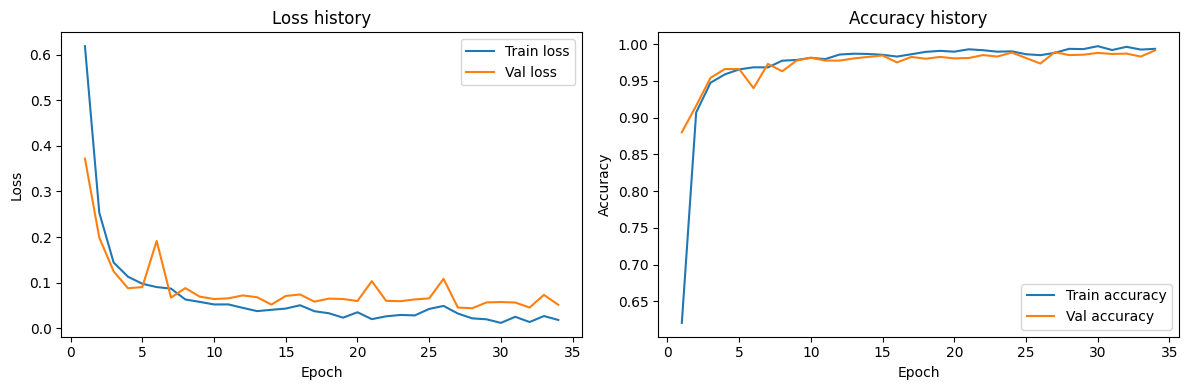

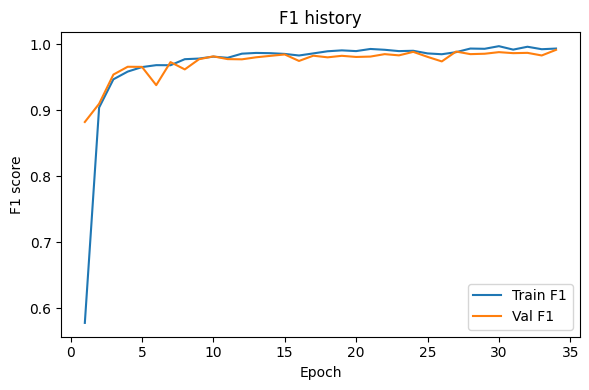

In [11]:
epochs = history_df["epoch"]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(epochs, history_df["train_loss"], label="Train loss")
axes[0].plot(epochs, history_df["val_loss"], label="Val loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss history")
axes[0].legend()

axes[1].plot(epochs, history_df["train_accuracy"], label="Train accuracy")
axes[1].plot(epochs, history_df["val_accuracy"], label="Val accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy history")
axes[1].legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, history_df["train_f1"], label="Train F1")
plt.plot(epochs, history_df["val_f1"], label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.title("F1 history")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
criterion = nn.CrossEntropyLoss()
final_metrics = run_epoch(model, val_loader, criterion, device, phase="val_eval")
print(
    "Validation evaluation -> "
    f"loss: {final_metrics['loss']:.4f}, "
    f"accuracy: {final_metrics['accuracy']:.4f}, "
    f"F1: {final_metrics['f1']:.4f}"
)


Validation evaluation -> loss: 0.0516, accuracy: 0.9915, F1: 0.9915


In [13]:
save_model = True

if save_model:
    artifacts_dir = Path("artifacts")
    artifacts_dir.mkdir(exist_ok=True)
    weights_path = artifacts_dir / "alexnet_classifier_weights.pth"

    torch.save(model.state_dict(), weights_path)
    print(f"Saved classifier weights to {weights_path}")

Saved classifier weights to artifacts\alexnet_classifier_weights.pth


## Random validation inferences

Inspect 10 random validation tiles, report their native resolution, and display the predicted class from the trained classifier.


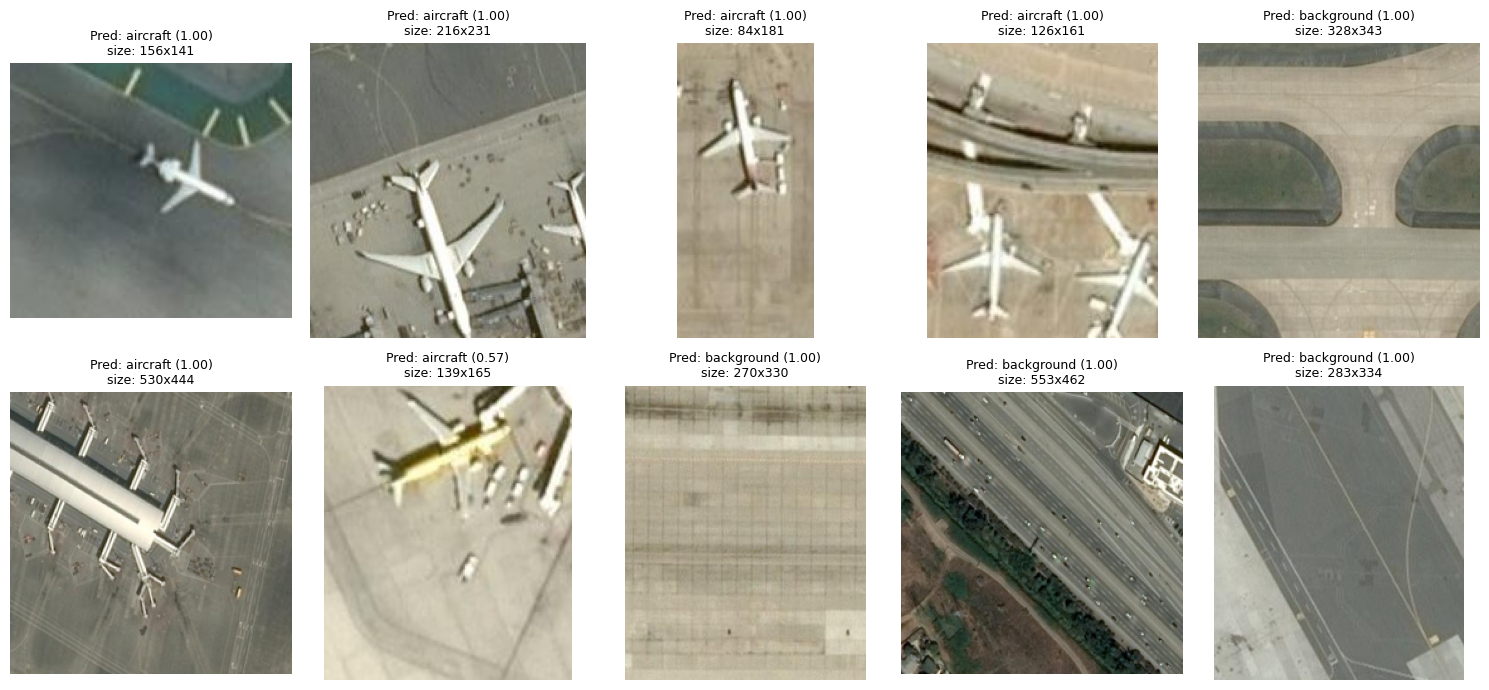

In [15]:
import math

weights_path = Path("artifacts/alexnet_classifier_weights.pth")
if not weights_path.exists():
    raise FileNotFoundError("Classifier weights not found. Train the model and export the weights first.")

inference_model = build_alexnet_classifier(num_classes=len(class_names)).to(device)
inference_model.load_state_dict(torch.load(weights_path, map_location=device))
inference_model.eval()

num_inference_samples = 10
sampled_entries = random.sample(val_samples, k=min(num_inference_samples, len(val_samples)))

cols = 5
rows = int(math.ceil(len(sampled_entries) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3.5))
axes = axes.flatten()

for ax, (image_path, _) in zip(axes, sampled_entries):
    with Image.open(image_path) as img:
        img = img.convert("RGB")
        width, height = img.size
        tensor = val_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = inference_model(tensor)
        probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()
        pred_idx = int(np.argmax(probs))
        pred_class = class_names[pred_idx]
        pred_conf = probs[pred_idx]

    display_img = img.resize((224, 224)) if max(width, height) > 512 else img
    ax.imshow(display_img)
    ax.set_title(
        f"Pred: {pred_class} ({pred_conf:.2f})\nsize: {width}x{height}", fontsize=9
    )
    ax.axis("off")

for ax in axes[len(sampled_entries):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

